In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

/home/aegis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
n_bins = 40
sample_size = 1

signal_sample_paths = {"SVJL":"SVJL.root.txt",
                      "QCD":"multijet_processed.txt",
                      "QCD_final":"QCD_bkg.root.txt",
                      "QCD_nMax2":"QCD_nMax2.root.txt"}

# bkg_dir = "samples/qcd_data_samples/"
bkg_dir = "/home/aegis/Artemis/NRAD/working_dir/samples/qcd_mc_samples/"
mc_dir = "/home/aegis/Artemis/NRAD/working_dir/samples/qcd_test_samples/"


In [3]:
var_names = ["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]

def name_map():
    return {
        "m_jj": "$m_{{\\rm jj}}$",
        "met": "MET",
        "ht": "$H_{{\\rm T}}$",
        "pT_j1": "Leading jet $p_{{\\rm T}}$",
        "pT_j2": "Sub-leading jet $p_{{\\rm T}}$",
        "tau21_j1": "Leading jet $\\tau_2/\\tau_1$",
        "tau21_j2": "Sub-leading jet $\\tau_2/\\tau_1$",
        "tau32_j1": "Leading jet $\\tau_3/\\tau_2$",
        "tau32_j2": "Sub-leading jet $\\tau_3/\\tau_2$",
        "min_dPhi": "min$\\Delta\\phi(\\rm j_i, \\rm MET)$",
    }

def unit_map():
    return {
        "m_jj": "(GeV)",
        "met": "(GeV)",
        "ht": "(GeV)",
        "pT_j1": "(GeV)",
        "pT_j2": "(GeV)",
        "tau21_j1": "",
        "tau21_j2": "",
        "tau32_j1": "",
        "tau32_j2": "",
        "min_dPhi": "",
    }


names = name_map()
units = unit_map()

bins_list = []
xlabel_list = []


for x in var_names:
    xlabel_list.append(f"{names[x]} {units[x]}")
    if "tau" in x:
        bins = np.linspace(0, 1, n_bins)
    elif x=="met":
        bins = np.linspace(0, 600, n_bins)
    elif x=="ht":
        bins = np.linspace(0, 4000, n_bins)
    elif x=="m_jj":
        bins = np.linspace(0, 4000, n_bins)
    bins_list.append(bins)


def load_samples(file):
    samples = np.loadtxt(file, dtype=str)
    # Get the names of all varibles
    variables = samples[0]
    # Get the events ordered by varibles
    events = np.asfarray(samples[1:])
    return variables, events


def sort_event_arr(names, variables, events):
    event_list = []
    for x in names:   
        ind_x = ind(variables, x)
        event_list.append(events[:, ind_x])
    return np.stack(event_list, axis=1)


def get_quality_events(arr):
    if np.isnan(arr).any():
        return arr[~np.isnan(arr).any(axis=1)]
    else:
        return arr
    
def ind(variables, name):
    return np.where(variables == name)[0][0]

In [4]:
HT_cut = 800    # In SR, HT > 800 GeV
MET_cut = 75
    
    
def plot_all_variables_appx(sig_list, bkg_list, mc_list, xlabels, bins_list=[], labels=["sig", "bkg"], 
                       name="sig_vs_bkg", title="", xlabel="x", outdir="./", 
                       plot_context_bounds = False, *args, **kwargs):
    csig1 = 'coral'
    csig2 = 'darkred'
    csig3 = 'goldenrod'
    cbkg = 'lightblue'
    cmc = 'green'
    sig_color = [csig1, csig2, csig3]

    N = 7
    
    if N==len(xlabels):
        fig, ax1 = plt.subplots(1, N, figsize=(5*N,5))
        ax1[0].set_ylabel("a.u.", fontsize = 24)
        
        for i in range(N):
           
            bins = bins_list[i]
            for n in range(len(sig_list)):
                ax1[i].hist(sig_list[n][i], bins = bins, density = True, histtype='step', ls= "-", color=sig_color[n], label=labels[n], lw=2)
            ax1[i].hist(bkg_list[i], bins = bins, density = True, histtype='stepfilled', ls= "-", color=cbkg, alpha=1, label=labels[-2])
            ax1[i].hist(mc_list[i], bins = bins, density = True, histtype='step', ls= "-", color=cmc, alpha=1, label=labels[-1], lw = 2)
            ax1[i].set_xlabel(xlabels[i], fontsize = 24)
            ax1[i].set_yticks([])
    
        if plot_context_bounds:
            ax1[0].axvline(HT_cut, color = "k", linestyle = "dashed", label="SR cuts")
            ax1[1].axvline(MET_cut, color = "k", linestyle = "dashed")
    
        ax1[0].legend(fontsize = 16, frameon = False)
        plt.subplots_adjust(wspace=.0, hspace=0)
#         plot_name = f"{outdir}/{name}_allsig.pdf"
#         plt.savefig(plot_name.replace(" ", "_"))
        plt.show()
    else:
        print("Wrong input lists!")

### Load Data

In [5]:
sig_events = {}

for sig_id in signal_sample_paths.keys():

    variables, loc_sig = load_samples(signal_sample_paths[sig_id])
    loc_sig = get_quality_events(loc_sig)
    sig_events[sig_id] = sort_event_arr(var_names, variables, loc_sig)
    
print(sig_events.keys())

dict_keys(['SVJL', 'QCD', 'QCD_final', 'QCD_nMax2'])


In [6]:
bkg_events_list = []
mc_events_list = []

print(f"Loading {sample_size} samples...")

for i in range(sample_size):

    bkg_path = f"{bkg_dir}/qcd_{i}.txt"
    if os.path.isfile(bkg_path):
        # Load input events ordered by varibles
        _, bkg_i = load_samples(bkg_path)
        bkg_i = get_quality_events(bkg_i)
        bkg_events_list.append(sort_event_arr(var_names, variables, bkg_i))

        
    mc_path = f"{mc_dir}/qcd_{i}.txt"
    if os.path.isfile(mc_path):
        # Load input events ordered by varibles
        _, mc_i = load_samples(mc_path)
        mc_i = get_quality_events(mc_i)
        mc_events_list.append(sort_event_arr(var_names, variables,mc_i))

        
if len(bkg_events_list)==0:
    print("No files loaded.")
print(bkg_events_list[0].shape)

Loading 1 samples...
(504751, 7)


In [7]:
bkg_events = np.concatenate(bkg_events_list)
# mc_events = np.concatenate(mc_events_list)
mc_events = sig_events['QCD_final']

print(len(bkg_events))
print(len(mc_events))

504751
14733


### Plot

3


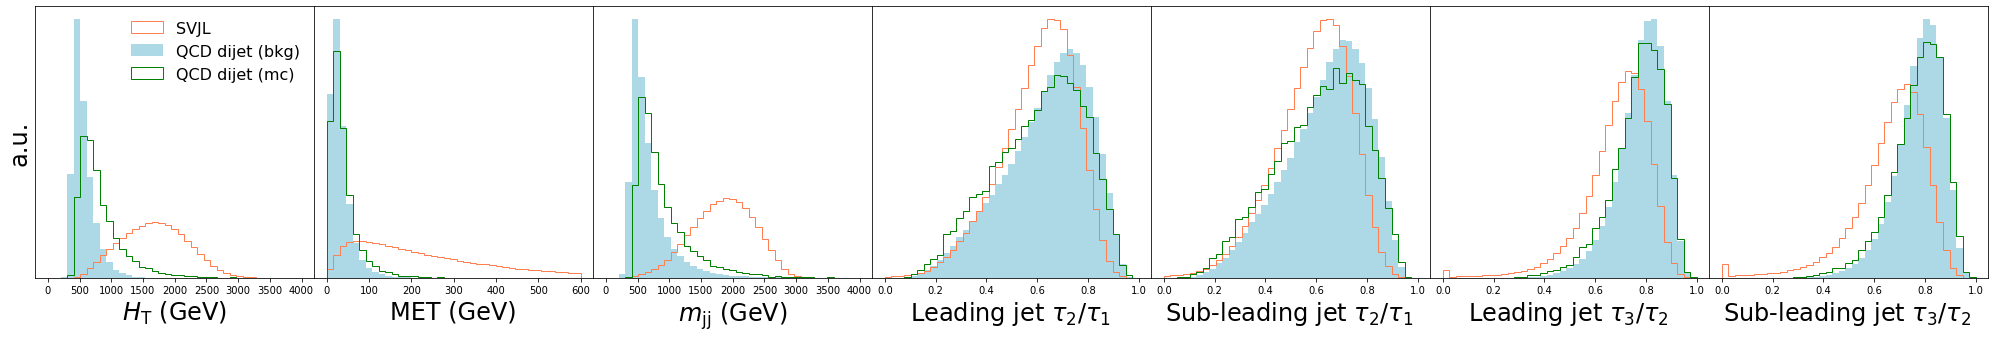

In [9]:

sig_id_to_plot = ['SVJL']
sig_list = []
sig_labels = []
for sig_id in sig_id_to_plot:
    sig_list.append(sig_events[sig_id].T)
    sig_labels.append(sig_id)
    
bkg_list = bkg_events.T
mc_list = mc_events.T
xlabels = xlabel_list
bins = bins_list
labels= sig_labels + ["QCD dijet (bkg)", "QCD dijet (mc)"]
print(len(labels))
# Signal vs background
plot_kwargs = {"bins_list":bins, "name":f"sig_vs_bkg_feat_morphmc", "labels":labels, "title":"Signal vs background in SR"}
plot_all_variables_appx(sig_list, bkg_list, mc_list, xlabels, **plot_kwargs)